# Cross_Cultural_Moderation

Goal:
    Examine whether the association between Self-Determination
    (TENS_Life_mean) and intervention-specific acceptance
    (Accept_avatar, Accept_chatbot, Accept_tele) depends on:
        - Cultural context (China vs USA)
        - Sample role (client vs therapist)

We fit:
- Baseline models with main effects only
- Contextual moderation models adding SDT × Country and SDT × Role simultaneously for each intervention outcome.

Key Steps:
- Load merged dataset
- Prepare contextual analysis sample and center key predictors
- Fit baseline and contextual-moderation models for each outcome
- Compare models and extract focal interaction terms
- Generate plot-ready predicted values for one focal outcome


# 0.0 Paths and Data Loading

In [2]:
from __future__ import annotations

import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 11

PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR = PROJECT_ROOT / "data" / "merged"
MERGED_PATH = DATA_DIR / "merged.csv"

merged = pd.read_csv(MERGED_PATH)
print("Raw merged shape:", merged.shape)
merged.head()

Raw merged shape: (2342, 273)


,AI_use_sum,AIavatar_CO_mean,AIavatar_EOU_mean,AIavatar_HC_mean,AIavatar_HM_mean,AIavatar_PPR_mean,AIavatar_SE_mean,AIavatar_TQE_mean,AIavatar_mean,Accept_avatar,...,gender,jobIT,role_label,would_you_use_1,would_you_use_2,would_you_use_3,would_you_use_4,would_you_use_5,would_you_use_6,would_you_use_7
0,7.0,4.0,4.0,2.75,3.5,2.5,4.0,4.000000,3.535714,3.702381,...,3.0,1.0,therapist,NaN,1.0,NaN,1.0,NaN,1.0,1.0
1,6.0,4.0,4.0,1.75,3.5,2.0,4.0,3.333333,3.226190,3.940476,...,3.0,1.0,therapist,NaN,1.0,1.0,1.0,NaN,1.0,1.0
2,3.0,3.0,3.0,3.00,3.0,3.0,3.0,2.666667,2.952381,2.964286,...,3.0,1.0,therapist,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,2.0,1.5,1.50,1.0,1.0,1.0,1.000000,1.285714,2.571429,...,3.0,1.0,client,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,3.0,2.5,3.0,3.00,3.0,3.0,3.0,3.000000,2.928571,3.000000,...,3.0,1.0,client,NaN,1.0,1.0,1.0,NaN,1.0,NaN


# 1.0. Contextual Moderation Sample and Centering

In [3]:
# Work on a copy to avoid side-effects
df = merged.copy()

# Keep a clean subset of variables needed for contextual moderation
contextual_vars = [
    "Accept_avatar", "Accept_chatbot", "Accept_tele",
    "TENS_Life_mean", "age", "gender", "Country", "role_label",
    "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean"
]

context_df = df[contextual_vars].copy()

print("Columns available for contextual moderation:")
print(sorted(context_df.columns))

Columns available for contextual moderation:
['Accept_avatar', 'Accept_chatbot', 'Accept_tele', 'Country', 'ET_mean', 'GAAIS_mean', 'PHQ5_mean', 'SSRPH_mean', 'TENS_Life_mean', 'age', 'gender', 'role_label']


In [4]:
# Center continuous predictors used in the contextual models
for col in ["TENS_Life_mean", "age"]:
    if col in context_df.columns:
        context_df[col + "_c"] = context_df[col] - context_df[col].mean()

print("Centered variables created:",
      [c for c in context_df.columns if c.endswith("_c")])

Centered variables created: ['TENS_Life_mean_c', 'age_c']


In [5]:
# inspect distributions of Country and role_label in the usable sample
print("Country distribution (overall):")
print(context_df["Country"].value_counts(dropna=False))

Country distribution (overall):
Country
USA      1857
China     485
Name: count, dtype: int64


In [6]:
print("Role_label distribution (overall):")
print(context_df["role_label"].value_counts(dropna=False))

Role_label distribution (overall):
role_label
unknown      1857
therapist     269
client        216
Name: count, dtype: int64


# 2.0. Fit and Compare Models
- Builds a listwise-complete sample for a given outcome
- Fits a baseline model (main effects only)
- Fits a contextual model with both SDT × Country and SDT × Role
- Prints key tables and returns both models for further use

In [7]:
def fit_contextual_models(outcome: str, data: pd.DataFrame):

    cols = [
        outcome,
        "TENS_Life_mean_c", "age_c", "gender", "Country", "role_label",
        "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean"
    ]

    sub_df = data[cols].dropna().copy()

    # focus on client vs therapist when role is used
    sub_df = sub_df[sub_df["role_label"].isin(["client", "therapist"])]

    if sub_df.empty:
        print(f"\n{outcome}: no complete cases for contextual model.")
        return None, None, None

    print(f"\n=== Contextual moderation for {outcome} (N={len(sub_df)}) ===")

    # Baseline model (main effects)
    baseline_formula = (
        f"{outcome} ~ TENS_Life_mean_c "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country) + C(role_label)"
    )

    baseline_model = smf.ols(formula=baseline_formula, data=sub_df).fit()
    print("\nBaseline model (main effects only):")
    print(baseline_model.summary().tables[1])

    # Contextual model (joint moderation by Country and Role)
    contextual_formula = (
        f"{outcome} ~ "
        "TENS_Life_mean_c * C(Country) "
        "+ TENS_Life_mean_c * C(role_label) "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean"
    )

    contextual_model = smf.ols(formula=contextual_formula, data=sub_df).fit()
    print("\nContextual model (TENS × Country and TENS × Role):")
    print(contextual_model.summary().tables[1])

    # Model comparison (optional)
    print("\nModel comparison (Baseline vs Contextual):")
    comp = anova_lm(baseline_model, contextual_model)
    print(comp)

    return sub_df, baseline_model, contextual_model


In [8]:
outcomes = ["Accept_avatar", "Accept_chatbot", "Accept_tele"]

# Ensure centered columns exist in context_df
if "TENS_Life_mean_c" not in context_df.columns and "TENS_Life_mean" in context_df.columns:
    context_df["TENS_Life_mean_c"] = context_df["TENS_Life_mean"] - context_df["TENS_Life_mean"].mean()
if "age_c" not in context_df.columns and "age" in context_df.columns:
    context_df["age_c"] = context_df["age"] - context_df["age"].mean()

context_models = {}

for outcome in outcomes:
    sub_df, base_m, ctx_m = fit_contextual_models(outcome, context_df)
    context_models[outcome] = {
        "data": sub_df,
        "baseline": base_m,
        "contextual": ctx_m,
    }



=== Contextual moderation for Accept_avatar (N=485) ===

Baseline model (main effects only):
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      2.3895      0.222     10.769      0.000       1.954       2.826
C(gender)[T.2.0]              -0.0411      0.042     -0.975      0.330      -0.124       0.042
C(gender)[T.3.0]              -0.5113      0.189     -2.701      0.007      -0.883      -0.139
C(role_label)[T.therapist]     0.0346      0.042      0.828      0.408      -0.048       0.117
TENS_Life_mean_c               0.2078      0.027      7.663      0.000       0.155       0.261
age_c                         -0.0016      0.003     -0.600      0.549      -0.007       0.004
PHQ5_mean                     -0.0420      0.025     -1.675      0.095      -0.091       0.007
SSRPH_mean                     0.0859      0.028   

# 3.0. Multicollinearity Check for a Focal Contextual Model
- Here we inspect VIFs for one outcome (e.g., Accept_chatbot)

In [9]:
focal_outcome = "Accept_chatbot"
focal_ctx_model = context_models[focal_outcome]["contextual"]

if focal_ctx_model is not None:
    X = focal_ctx_model.model.exog
    names = focal_ctx_model.model.exog_names

    vif_rows = []
    for i, name in enumerate(names):
        if name == "Intercept":
            continue
        vif_val = variance_inflation_factor(X, i)
        vif_rows.append({"variable": name, "VIF": vif_val})

    vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)

    print(f"Variance Inflation Factors – Contextual model for {focal_outcome}:")
    display(vif_df)

Variance Inflation Factors – Contextual model for Accept_chatbot:


,variable,VIF
3,TENS_Life_mean_c,2.981241
4,TENS_Life_mean_c:C(role_label)[T.therapist],2.585397
9,ET_mean,1.579746
7,SSRPH_mean,1.577027
6,PHQ5_mean,1.476411
8,GAAIS_mean,1.266426
0,C(role_label)[T.therapist],1.242688
1,C(gender)[T.2.0],1.066131
5,age_c,1.065263
2,C(gender)[T.3.0],1.049508


# 4.0. Residual Diagnostics for the Focal Contextual Model

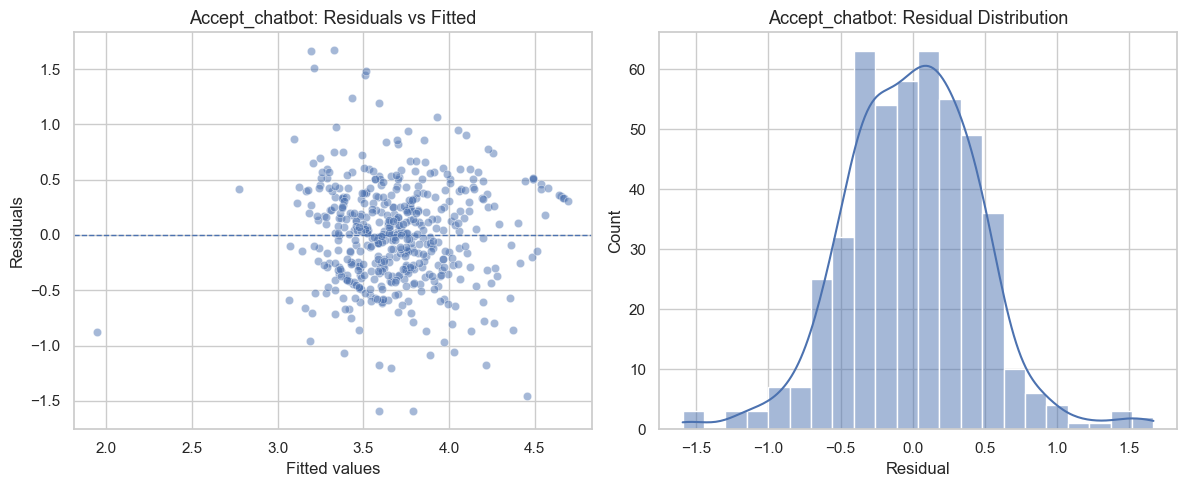

In [ ]:
if focal_ctx_model is not None:
    focal_df = context_models[focal_outcome]["data"].copy()
    focal_df["fitted"] = focal_ctx_model.fittedvalues
    focal_df["resid"] = focal_ctx_model.resid

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Residuals vs fitted
    sns.scatterplot(x="fitted", y="resid", data=focal_df, ax=axes[0], alpha=0.5)
    axes[0].axhline(0, linestyle="--", linewidth=1)
    axes[0].set_xlabel("Fitted values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"{focal_outcome}: Residuals vs Fitted")

    # Residual distribution
    sns.histplot(focal_df["resid"], kde=True, ax=axes[1])
    axes[1].set_title(f"{focal_outcome}: Residual Distribution")
    axes[1].set_xlabel("Residual")

    plt.tight_layout()
    plt.show()

# 5.0. Plot-Ready Predictions: SDT × Country × Role
- This builds a grid over SDT (TENS) and generates predicted acceptance for each combination of Country × role_label, so you can visualize how the SDT slope changes by context.

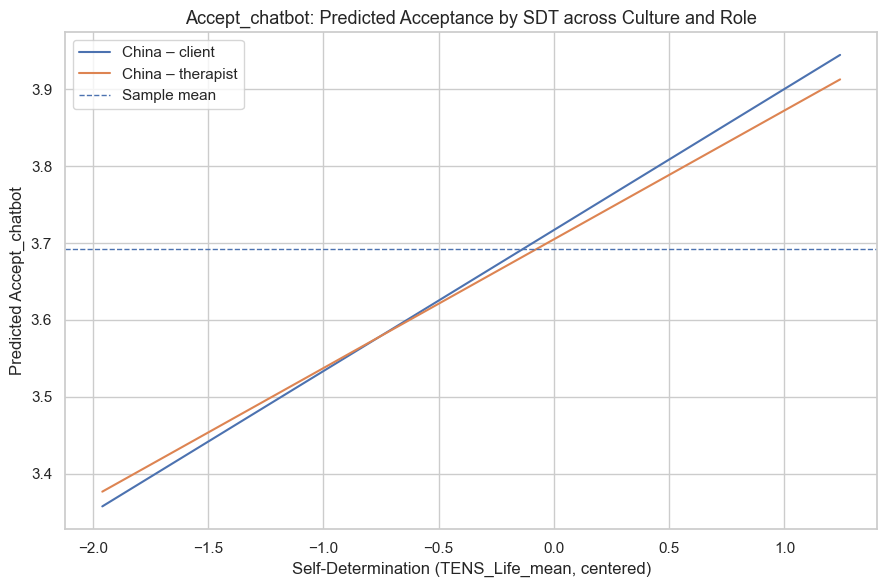

In [11]:
if focal_ctx_model is not None:
    focal_df = context_models[focal_outcome]["data"]

    # Define grid for TENS (SDT)
    tens_min = focal_df["TENS_Life_mean_c"].quantile(0.05)
    tens_max = focal_df["TENS_Life_mean_c"].quantile(0.95)
    tens_grid = np.linspace(tens_min, tens_max, 50)

    # Use most common levels for nuisance covariates
    gender_ref = focal_df["gender"].mode()[0]
    country_levels = focal_df["Country"].dropna().unique()
    role_levels = focal_df["role_label"].dropna().unique()

    age_mean = 0.0  # centered
    phq_mean = focal_df["PHQ5_mean"].mean()
    ssrph_mean = focal_df["SSRPH_mean"].mean()
    gaa_mean = focal_df["GAAIS_mean"].mean()
    et_mean = focal_df["ET_mean"].mean()

    pred_rows = []
    for country in country_levels:
        for role in role_levels:
            for t_val in tens_grid:
                pred_rows.append({
                    "TENS_Life_mean_c": t_val,
                    "age_c": age_mean,
                    "gender": gender_ref,
                    "Country": country,
                    "role_label": role,
                    "PHQ5_mean": phq_mean,
                    "SSRPH_mean": ssrph_mean,
                    "GAAIS_mean": gaa_mean,
                    "ET_mean": et_mean,
                })

    pred_df = pd.DataFrame(pred_rows)
    pred_df["pred"] = focal_ctx_model.predict(pred_df)

    # Plot: separate line per Country × Role
    plt.figure(figsize=(9, 6))
    for (country, role), grp in pred_df.groupby(["Country", "role_label"]):
        label = f"{country} – {role}"
        sns.lineplot(
            x="TENS_Life_mean_c",
            y="pred",
            data=grp,
            label=label,
        )

    plt.axhline(focal_df[focal_outcome].mean(), linestyle="--", linewidth=1,
                label="Sample mean")
    plt.xlabel("Self-Determination (TENS_Life_mean, centered)")
    plt.ylabel(f"Predicted {focal_outcome}")
    plt.title(f"{focal_outcome}: Predicted Acceptance by SDT across Culture and Role")
    plt.legend()
    plt.tight_layout()
    plt.show()